# Wilcoxon test and raw stats extraction from tl123 data

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

## Load data

In [2]:
network_type = "tl123_edges"

df_merged = pd.DataFrame()
edas = {}

for i in range(1, 4, 1):
    eda_path = Path(f"analysis/{network_type}/{i}_eda.csv")
    eda = pd.read_csv(eda_path, index_col=0)
    edas[f"{i}"] = eda
    df_merged = pd.concat([df_merged, eda], ignore_index=True)

edas["concatenated"] = df_merged


## Select columns to be used in the test

In [3]:
investigated_cols = [
    "metric_level gained",
    "interact_classmates",
    "metric_Gender",
    "interaction_groupintegration",
    "psycho_motivationdegree",
    "psycho_proficiencyingroup_BAL1",
    "betweenness_weighted",
    "pagerank_weighhted",
    "voterank",
]

edas = {n: e[investigated_cols] for n, e in edas.items()}

## Clean & normalise data

In [4]:
for n, e in edas.items():
    print(f"{n}\n\n\n")
    cols_with_nans = []
    for col in e.columns:
        if e[col].isnull().values.any():
            print(col, e[col].unique())
            cols_with_nans.append(col)
    edas[n] = e.fillna({col: 0 for col in cols_with_nans})

1



voterank [nan 12.  1.  4. 15.  5.  3. 10. 11. 13. 18. 16.  7.  9. 14.  0.  6. 17.
  8.]
2



metric_level gained [0.27272727 0.09090909 0.         0.18181818 0.36363636        nan]
interact_classmates [0.7  0.5  0.9  0.6  0.75 0.4  0.35 0.8  0.65 0.2  0.3   nan 0.18]
interaction_groupintegration [0.8 nan 0.6 1.  0.4]
psycho_proficiencyingroup_BAL1 [0.33333333 0.66666667 1.                nan]
voterank [15. 16.  1.  6. 17. nan  8.  2. 14. 11. 20.  9.  4. 12. 19.  5. 18.  7.
 10. 13.  3.]
3



metric_level gained [0.27272727 0.09090909 0.18181818 0.36363636        nan]
interact_classmates [0.3  0.33 0.75 0.7  0.6  0.5  0.8   nan 0.66 0.25 0.18 0.15 0.95]
interaction_groupintegration [1.  0.8 0.2 0.6 nan]
psycho_motivationdegree [1.  0.8 nan 0.6 0.4]
psycho_proficiencyingroup_BAL1 [0.33333333 0.66666667 1.                nan]
voterank [nan  3.  1.  7. 14.  4.  0.  5.  9.  8. 13.  6. 11. 10. 15.  2.]
concatenated



metric_level gained [0.18181818 0.27272727 0.09090909 0.         0.36

In [5]:
for e in edas.values():
    print(e.dtypes)

metric_level gained               float64
interact_classmates               float64
metric_Gender                      object
interaction_groupintegration      float64
psycho_motivationdegree           float64
psycho_proficiencyingroup_BAL1    float64
betweenness_weighted              float64
pagerank_weighhted                float64
voterank                          float64
dtype: object
metric_level gained               float64
interact_classmates               float64
metric_Gender                      object
interaction_groupintegration      float64
psycho_motivationdegree           float64
psycho_proficiencyingroup_BAL1    float64
betweenness_weighted              float64
pagerank_weighhted                float64
voterank                          float64
dtype: object
metric_level gained               float64
interact_classmates               float64
metric_Gender                      object
interaction_groupintegration      float64
psycho_motivationdegree           float64
psycho

In [6]:
for n, e in edas.items():
    _df = e.loc[:, e.columns != "metric_Gender"]
    _df=(_df-_df.min())/(_df.max()-_df.min())
    df_norm = pd.concat([e["metric_Gender"], _df], axis=1)
    edas[n] = df_norm

1
2
3
concatenated


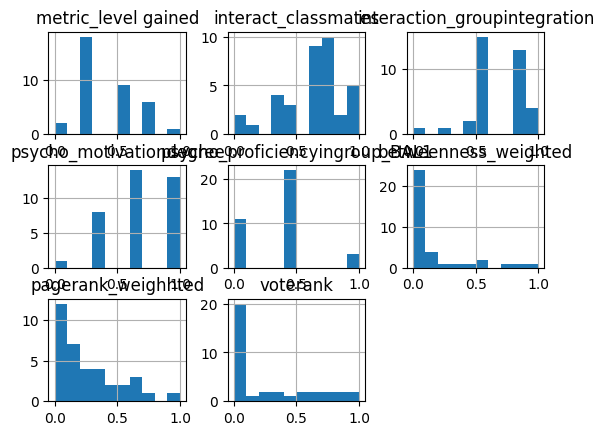

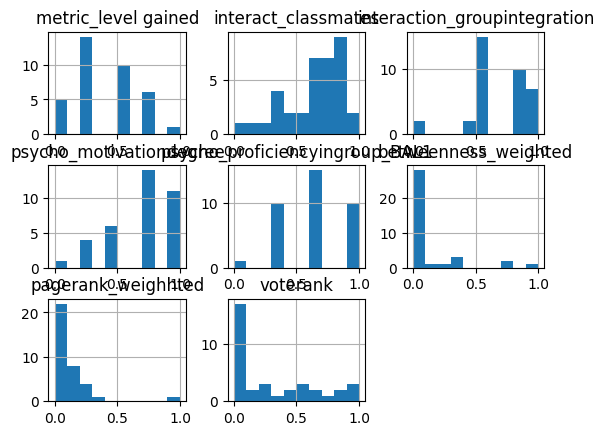

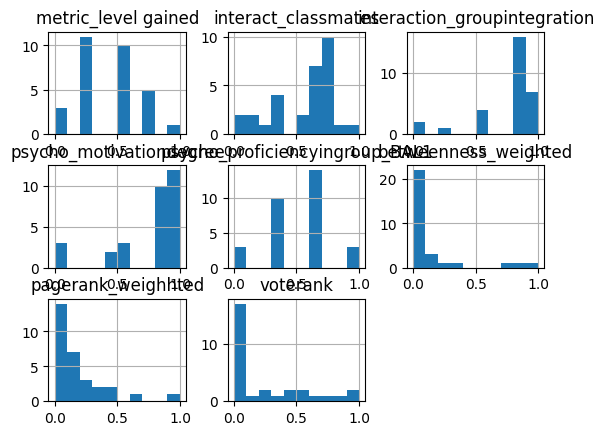

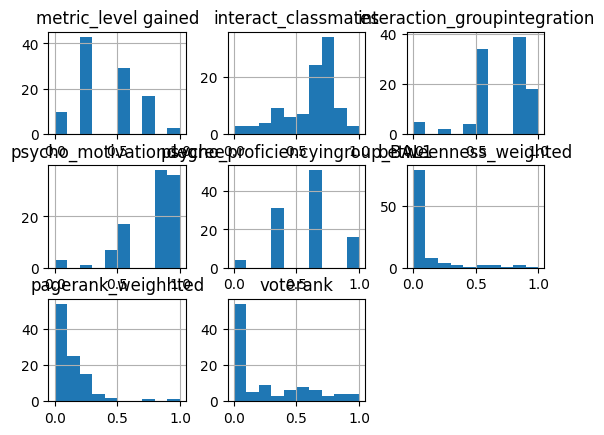

In [7]:
for n, e in edas.items():
    print(n)
    e.hist()


As we can see - distributions certainly don't come from normal distribution

## Split by gender

In [8]:
def split_by_gender(df):
    df_female = df.loc[df["metric_Gender"] == "female"].drop("metric_Gender", axis=1)
    df_male = df.loc[df["metric_Gender"] == "male"].drop("metric_Gender", axis=1)
    assert len(df_female) + len(df_male) == len(df)
    return {"female": df_female, "male": df_male}

edas_split = {name: split_by_gender(eda) for name, eda in edas.items()}

## Perform Wilcoxon test

In [9]:
import numpy as np

from scipy.stats import ranksums

#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (
        np.mean(x) - np.mean(y)) / np.sqrt(((nx-1) * np.std(x, ddof=1) ** 2 + (ny-1) * np.std(y, ddof=1) ** 2) / dof
    )

def test_samples(x: np.ndarray, y: np.ndarray) -> dict:
    result = ranksums(x=x, y=y, alternative="two-sided")
    # cd = cohen_d(x, y)
    return {"p_value": result.pvalue, "statistic": result.statistic} # , "cohen_d": cd}

def compute_stats(x: np.ndarray) -> dict:
    return {"mean": x.mean(), "std": x.std(), "size": len(x)}


In [10]:
wilcoxon_rank_sum_test = []

for snapshot, eda in edas_split.items():
    for col in eda["female"].columns:
        f_feature = eda["female"][col].to_numpy()
        m_feature = eda["male"][col].to_numpy()
        stats = test_samples(f_feature, m_feature)
        wilcoxon_rank_sum_test.append({"snapshot": snapshot, "feature": col, **stats})

pd.DataFrame(wilcoxon_rank_sum_test).to_csv("wilcoxon_rank_sum_test.csv")

In [11]:
raw_stats = []

for snapshot, eda in edas_split.items():
    for gender in ["female", "male"]:
        for col in eda[gender].columns:
            f_feature = eda[gender][col].to_numpy()
            raw_stats.append(
                {"snapshot": snapshot, "feature": col, "gender": gender, **compute_stats(f_feature)}
            )

pd.DataFrame(raw_stats).to_csv("raw_stats.csv")